In [15]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas
import seaborn as sns

from asapdiscovery.data.backend.openeye import oechem, oegraphsim, smiles_to_oemol
from asapdiscovery.ml.config import DatasetConfig, DatasetSplitterConfig

%matplotlib inline

In [4]:
ds_dir = Path("../ml_datasets/")
ds_paths_dict = {
    "Moonshot": ds_dir / "moonshot_gat_config.json",
    "SARS": ds_dir / "sars_gat_config.json",
    "MERS": ds_dir / "mers_gat_config.json",
}
full_ds_dict = {
    lab: DatasetConfig(**json.loads(p.read_text())).build()
    for lab, p in ds_paths_dict.items()
}

ds_splitter = DatasetSplitterConfig(
    split_type="temporal", train_frac=0.9, val_frac=0.1, test_frac=0
)
split_ds_dict = {lab: ds_splitter.split(ds) for lab, ds in full_ds_dict.items()}

loading from cache
loading from cache
loading from cache


In [28]:
test_ds = DatasetConfig(
    **json.loads((ds_dir / "test_data_gat_config.json").read_text())
).build()
test_mols = [smiles_to_oemol(d["smiles"]) for _, d in test_ds]
test_mols[:10]

loading from cache


[<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7fed4238db00> >,
 <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7fed4238ced0> >,
 <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7fed4238ff90> >,
 <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7fed4238dfb0> >,
 <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7fed4238cc00> >,
 <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7fed4238e820> >,
 <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7fed4238f540> >,
 <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7fed4238c480> >,
 <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7fed4238e0a0> >,
 <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7fed4238cfc0> >]

In [5]:
next(iter(split_ds_dict.items()))

('Moonshot',
  <torch.utils.data.dataset.Subset at 0x7fed55f5ceb0>])

In [6]:
next(iter(split_ds_dict.values()))[0][0]

(('NA', 'AGN-NEW-891393a6-1'),
 {'smiles': 'COc1cc(cc(c1)Cl)OC(=O)Nc2cccnc2',
  'g': Graph(num_nodes=19, num_edges=59,
        ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
        edata_schemes={}),
  'compound': ('NA', 'AGN-NEW-891393a6-1'),
  'pIC50': 5.18,
  'pIC50_range': 0.0,
  'pIC50_stderr': 0.02,
  'dG': -7.077887067048149,
  'dG_stderr': 0.0314008730915826,
  'dG_95ci_lower': -7.142247580985395,
  'dG_95ci_upper': -7.016644088619064,
  'dG_kT': -11.952117543748043,
  'dG_kT_stderr': 0.0530252775456379,
  'dG_kT_95ci_lower': -12.060800321597847,
  'dG_kT_95ci_upper': -11.848699211415296,
  'date_created': datetime.date(2020, 4, 23)})

In [13]:
compound_df = []
for lab, (train, val, _) in split_ds_dict.items():
    all_compound_ids = [compound[1] for split in [train, val] for compound, _ in split]
    all_pic50s = [d["pIC50"] for split in [train, val] for _, d in split]
    all_smiles = [d["smiles"] for split in [train, val] for _, d in split]
    split_lab = ["Train"] * len(train) + ["Val"] * len(val)
    compound_df.append(
        pandas.DataFrame(
            {
                "compound_id": all_compound_ids,
                "pIC50": all_pic50s,
                "smiles": all_smiles,
                "Split": split_lab,
                "Dataset": lab,
            }
        )
    )
compound_df = pandas.concat(compound_df, axis=0, ignore_index=True)
compound_df

,compound_id,pIC50,smiles,Split,Dataset
0,AGN-NEW-891393a6-1,5.18,COc1cc(cc(c1)Cl)OC(=O)Nc2cccnc2,Train,Moonshot
1,BAR-COM-4e090d3a-6,4.45,Cn1c2ccccc2nc1C(c3ccccc3)NC(=O)Cc4cnnn4C,Train,Moonshot
2,CHR-SOS-7098f804-10,4.62,c1cc(c(cc1Cl)C(=O)Nc2cnccc2Cl)O,Train,Moonshot
3,CHR-SOS-7098f804-14,4.41,c1ccc(cc1)c2ccc(cc2C(=O)Nc3cccnc3)Cl,Train,Moonshot
4,DAR-DIA-23aa0b97-20,4.21,c1ccc(cc1)NC(=O)Cc2cncc3c2cccc3,Train,Moonshot
...,...,...,...,...,...
3612,ASAP-0031882,5.27,c1ccc2c(c1)cncc2CC(=O)N3CCC(CC3)[C@H]4CCOC4,Val,MERS
3613,ASAP-0031887,5.11,c1ccc2c(c1)cncc2CC(=O)N3CCCC4(C3)CC4,Val,MERS
3614,ASAP-0031888,5.24,CC(=O)N[C@@H]1CCCN(C1)C(=O)Cc2cncc3c2cccc3,Val,MERS
3615,ASAP-0031893,5.26,c1ccc2c(c1)cncc2CC(=O)N3CCC[C@@H](C3)OC(=O)N,Val,MERS


In [36]:
size_dict = {lab: len(g) for lab, g in compound_df.groupby("Dataset")}
size_dict

{'MERS': 896, 'Moonshot': 1614, 'SARS': 1107}

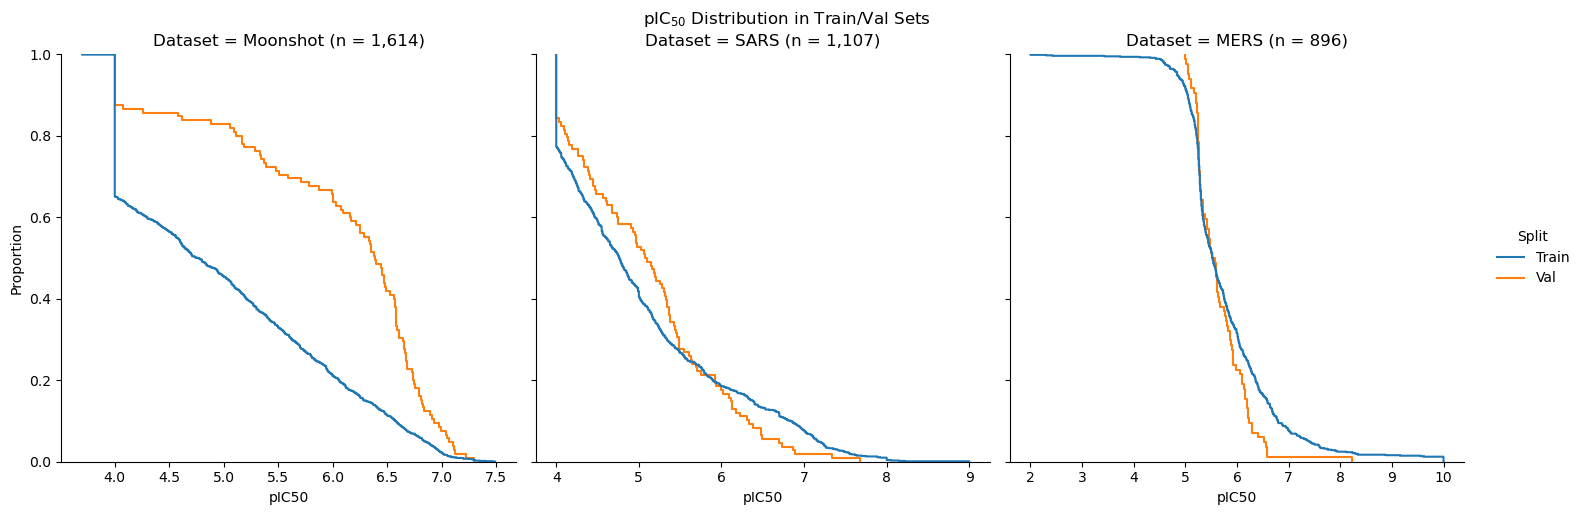

In [37]:
fg = sns.displot(
    pic50_df,
    x="pIC50",
    hue="Split",
    hue_order=["Train", "Val"],
    col="Dataset",
    col_order=["Moonshot", "SARS", "MERS"],
    kind="ecdf",
    complementary=True,
    facet_kws={"sharex": False},
)

# fg.set_titles(template="{col_var} = {col_name}
for lab, ax in fg.axes_dict.items():
    ax.set_title(f"Dataset = {lab} (n = {size_dict[lab]:,})")
fg.figure.suptitle("pIC$_{50}$ Distribution in Train/Val Sets", y=1.02)
fg.savefig("../figures/pic50_dist.png", dpi=200, bbox_inches="tight")

In [29]:
mol_sim_df = []
for lab, (train, val, _) in split_ds_dict.items():
    train_mols = [smiles_to_oemol(d["smiles"]) for _, d in train]
    val_mols = [smiles_to_oemol(d["smiles"]) for _, d in val]

    train_fp_db = oegraphsim.OEFPDatabase(oegraphsim.OEFPType_MACCS166)
    for mol in train_mols:
        if train_fp_db.AddFP(mol) == -1:
            print(oechem.OEMolToSmiles(mol), "failed", flush=True)

    val_similarity = [
        next(iter(train_fp_db.GetSortedScores(mol, 1))).GetScore() for mol in val_mols
    ]
    test_similarity = [
        next(iter(train_fp_db.GetSortedScores(mol, 1))).GetScore() for mol in test_mols
    ]
    
    mol_sim_df.append(
        pandas.DataFrame(
            {
                "Dataset": lab,
                "Max Similarity": val_similarity + test_similarity,
                "Split": ["Val"] * len(val_similarity) + ["Test"] * len(test_similarity),
            }
        )
    )
mol_sim_df = pandas.concat(mol_sim_df, axis=0, ignore_index=True)
mol_sim_df

,Dataset,Max Similarity,Split
0,Moonshot,0.864198,Val
1,Moonshot,0.982143,Val
2,Moonshot,0.952381,Val
3,Moonshot,0.953846,Val
4,Moonshot,0.830508,Val
...,...,...,...
1183,MERS,0.911111,Test
1184,MERS,0.911111,Test
1185,MERS,0.941176,Test
1186,MERS,1.000000,Test


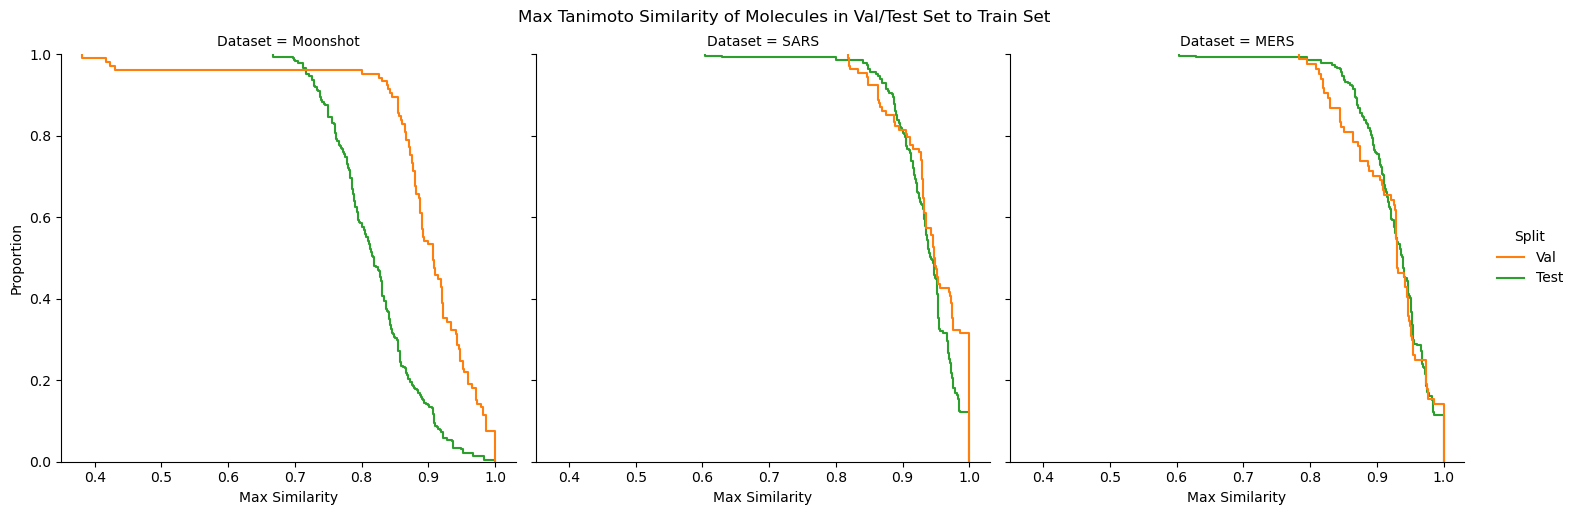

In [33]:
color_palette = dict(zip(["Val", "Test"], sns.color_palette()[1:]))
fg = sns.displot(
    mol_sim_df,
    x="Max Similarity",
    hue="Split",
    hue_order=["Val", "Test"],
    palette=color_palette,
    col="Dataset",
    col_order=["Moonshot", "SARS", "MERS"],
    kind="ecdf",
    complementary=True,
)
fg.figure.suptitle("Max Tanimoto Similarity of Molecules in Val/Test Set to Train Set", y=1.02)
fg.savefig("../figures/tanimoto_sim_dist.png", dpi=200, bbox_inches="tight")